# Finding the right model

In [271]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing importStandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV

import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Drop the Irrelevant Columns
We are hoping to predict student success by using only data that can be collected anonymously by the online learning platform itself based directly on student behavior, so we need to drop data that those services might not have.  Our dataset includes demographic data such as gender, disability, age, and socio-economics, but we will not use those for prediction.  In our EDA, we found that demographic data was not strongly correlated to course outcomes anyway.

## Set Prediction Window to .5
We want to make timely predictions to intervene with students in time to help them succeed, so we will only use data from the first half of the shortest course.  This approach is a compromise.  By only using part of the data we are handicapping our model in its ability to make predictions.  On the other hand we are able to produce a prediction to red-flag students before the end of the course so instructors or the system can intervene.

By halfway through the course we've lost about half of the student who would eventually withdraw, but if we set our prediction window earlier, our model loses accuracy and still misses those students and the ones who will fail.  It also recommends more interventions for students who don't need them.  The halfway point seems like a reasonable compromise, but the function that loads the data allows this window to be changed if needed.

In [2]:
df = load_OU_data(prediction_window=.5)
df.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,num_of_prev_attempts,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,0,Pass,26,121,628,3,81.000000
1,AAA,0,Pass,45,266,896,2,69.000000
2,AAA,0,Pass,68,371,1231,3,72.333333
3,AAA,0,Pass,40,207,747,2,49.500000
4,AAA,0,Pass,70,365,1271,3,74.000000


## Preprocessing
We will separate our target variable from the predictor variables into X and y variables respectively, and then divide the dataset into 4 subgroups to be used to validate the accuracy of our model on new data, train and test, which will be used to validate our final model, and 't' (an intermediate training test) and 'val' which will be used to evaluate model candidates along the way.  When we use cross-validation the 't' set will be further divided.  While this gives our models less data to train on, it maximizes our ability to ensure that validity of our models and identify any overfitting.

## Collapse targets
This dataset divides outcomes into four categories: 'Distinction','Pass','Fail','Withdrawn'.  We want to separate students into "Needs Intervention" and "Does Not Need Intervention."  To that end, we will combine targets in the target variable.  'Distinction' and 'Pass' will both become "No Intervention" and "Fail" and "Withdrawn" will become "Needs Intervention."  This improves model accuracy as well as creating more clear metrics and a simpler recommender system.

In [ ]:
X = df.drop(columns = ['final_result'])
y = df['final_result']

binary_y = np.array(['No Intervention' if label in ['Distinction','Pass'] 
            else 'Needs Intervention' for label in y])

#Check the class balance
display(np.unique(binary_y,return_counts=True))

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

cs = CourseScaler()

X_train, X_test, y_train, y_test = train_test_split(X, binary_y, random_state=111, test_size=0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=0.2)

# CourseScaler class and smotecourses() function
We run into a problem with our data because this dataset comprises 7 different courses and each course has different numbers of activities, assessments, and demands different amounts of work.  This creates a variable in the data which is unrelated to the actual student activity or effort, but is intrinsic in the course itself.  We can partially over come this, making our model more general, by normalizing the activity statistics for each course.  In other words, while 100 activities may be sufficient to succeed in course A, 200 activities may be necessary for course B.  Instead, we take the mean of all students' activitiy counts and divide by the standard deviation.  Now the necessary activities for course A and B are set to the same value, more or less.  

This is what the `CourseScaler` transformer does. It can fit on and transform the training data and then use the mean and standard deviation from the training data to transform the test data on the same scale.

But, different courses don't also have different work requirements, they also have different success rates, which will also bias the predictions.  The solution is to balance the classes in each course to remove this bias as well, which is what the function `smotecourses()` does.  SMOTE is a class from [Imbalanced Learn](https://imbalanced-learn.org/stable/index.html) which creates synthetic data as a way of upsampling a minority class without directly duplicating observations.  It uses a K-neartest neighbors approach to create new observations with very similar features to others.  Once the minority class is smoted, the classes are balanced in each course and the bias is removed.  For the purposes of training our model, each course has the same graduation rate and requires the same level of effort and grades assessments on the same scale.  See the readme for a more on why this is important.

I wrap these into the `process_courses()` function, which returns scaled and smoted training set and a test set scaled on the CourseScaler fitted on the train set (but not smoted)

With these solutions we can overcome the bias that different courses would have otherwise introduced into our dataset.

# When do we transform?
We are going to create transformed versions of the above datasets for use in evaluating models.  However our custom course_cross_validate function will automatically perform these transformations on each cross-validation fold during it's hyperparameter search to prevent data leakage during cross validation.  When we cross-validate models we will only give them the X_t and y_t datasets.

In [283]:

transformed_big_data = process_courses(X_train, y_train, X_test, y_test)
X_train_transformed, y_ttrain_transformed, X_test_transformed, y_test = transformed_big_data
transformed_little_data = process_courses(X_t, y_t, X_val, y_val)
X_t_transformed, y_t_transformed, X_val_transformed, y_val = transformed_little_data

# FSM
A decent start for a baseline model, a logistic regresson model seeks the best fit line to model the linear relationship between the predictor variables, X, and the target variable, y, which is a linear regression. It then applies a sigmoid function to that line to assign probabilities that each observation belongs in one class or the other.  For our purposes, if the probability of an observation belonging a class is greater than .5, then we will predict that it belongs to that class.  We will use our custom cross_validate function to remove the course bias.

[0.7464887640449438, 0.7228661749209695, 0.7316473480857042, 0.7393747804706708, 0.7411310151036179]
Mean cross validated accuracy:
0.7363016165251812
validation accuracy: 
0.7264044943820225
LogisticRegression()


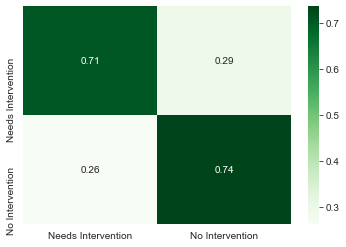

In [285]:
lr = LogisticRegression()

scores = course_cross_validate(lr,X_t,y_t,scoring='accuracy', cv=cv, random_state = 111)

print(scores)
print('Mean cross validated accuracy:')
print(np.mean(scores))
lr.fit(X_t_transformed,y_t_transformed)
y_pred = lr.predict(X_val_transformed)
print('validation accuracy: ')
print(accuracy_score(y_val, y_pred))
plot_confusion(y_val, y_pred, cmap='Greens', save_path='../figures/FSMconfusionmatrix.png')
pickle.dump(lr,open('../models/FSM2.pkl','wb'))
print(lr)

### Evaluation
The FSM achieves 73.6% accuracy with a good balance between course predictions.  This is a lovely start, but let's see if we can do better.

## GridsearchCV for best logistic regression hyperparameters

best model
LogisticRegression(l1_ratio=0.7, penalty='l1', random_state=111,
                   solver='liblinear')
best cv
[0.7468398876404494, 0.7232174218475589, 0.7316473480857042, 0.7397260273972602, 0.7411310151036179]
cross validated accuracy score:
0.736512340014918
validation accuracy: 
0.7269662921348314
validation set confusion matrix


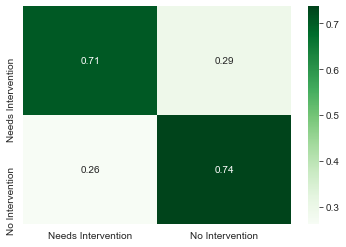

In [273]:
LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.1,.5,.7]},
          {'solver':['saga','liblinear'],
          'penalty':['l1']}]


LRgrid = Course_GridSearchCV(LogisticRegression(), LRparams, cv=cv, 
                                scoring='accuracy', verbose = True)

LRgrid.fit(X_t, y_t)
LRmodel = score_grid(LRgrid, X_val_transformed, y_val)
pickle.dump(LRmodel,open('../models/LRmodel2.pkl','wb'))

## Logistic Regression Evaluation
By optimizing the hyperparameters of the logistic regression model, which are all regularization parameters, we've barely moved the needle at all.  We gained .0002 accuracy.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use Course_GridsearchCV to optimize the hyperparameters for these as well.

# Decision Tree
A decision tree is a promising candidate for this problem because it does not assume the independence of the features. Instead it seeks to find the best way to divide and subdivide the data in a tree structure based on the values of different variables.  We can tune how many features each split is allowed to consider.  Once the tree is build predictions are made by sending an observations down the tree sending it on a path to the predicted class as it reaches each split in the tree is sent in one or the other direction.  You can think of it like a deterministic Pachinko machine!

best model
DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=5,
                       min_samples_split=0.5, random_state=111,
                       splitter='random')
best cv
[0.7626404494382022, 0.7168949771689498, 0.7418335089567967, 0.7551808921671935, 0.7492096944151738]
cross validated accuracy score:
0.7451519044292633
validation accuracy: 
0.7353932584269663
validation set confusion matrix


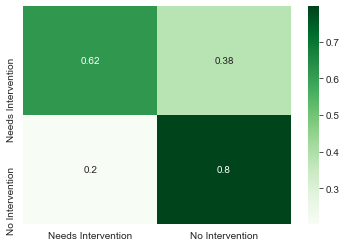

In [288]:
DTparams = {'criterion':['gini','entropy'],
           'splitter':['best','random'],
           'max_depth':[4,10],'min_samples_split':[.01,.1,.2,.5],
           'max_features':[1,2,3,4,5],'random_state':[111]}
           
DTgrid = Course_GridSearchCV(DecisionTreeClassifier(), DTparams, cv=cv, scoring = 'accuracy')

DTgrid.fit(X_t, y_t)

DTmodel = score_grid(DTgrid, X_val_transformed, y_val, cmap = 'Greens')
plt.savefig('../figures/DTconfmatrix.png',dpi=250)
pickle.dump(GNBmodel,open('../content/DTmodel2.pkl','wb'))

### Decision Tree Evaluation 
As expected, this model is better at predicting how a student will do.  It doesn't rely on establishing a straight line through the data to model it, which is probably not the best approach in this problem space.  We see a nice increase in accuracy here.

# Random Forest Classifier
This is an interesting extension to the decision tree model.  It creates a whole forest of decision trees and trains each one on a subset of the data and a subset of the features.  This is a technique called bagging, or [Boostrap AGGregation](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) (check the link for more on this).  It works on the principle that a bunch of bad predictors, on average will be more accurate than one good predictor.  This worked for Francis Galton in [guessing the weight of an ox](https://crowdsourcingweek.com/blog/using-the-crowd-to-predict/), maybe it will work here!

In [ ]:
RFparams = {'n_estimators':[10,100,150],
           'criterion':['gini','entropy'],
           'max_depth':[4],
           'min_samples_split':[2,4,5],
           'oob_score':[True,False],
            'bootstrap':[True,False]
           'n_jobs':[-1],'random_state':[111],
           'max_samples':[.5,.7,None]}
           
RFgrid = Course_GridSearchCV(RandomForestClassifier(), RFparams, cv=cv)

RFgrid.fit(X_t, y_t)

RFmodel = score_grid(RFgrid, X_val_transformed, y_val, save_path = '../figures/RFmodel2confmatrix.png')
pickle.dump(RFmodel, open('../models/RFmodel2.pkl','wb'))

### Random Forest Classifier Evaluation:
Apparently bagging is not the right approach to this problem.  Our single well tuned decision tree outperformed the random forest classifier.  I guess the wisdom of the crowd is not always superior to the wisdom of the expert!

# eXtreme Gradient Boost model:
XGBoost models have gained a lot of popularity recently and won a lot of Kaggle competitions.  It uses another popular idea called [boosting](https://en.wikipedia.org/wiki/Gradient_boosting).  That's a pretty involved wikipedia article, but the TLDR is that it's a similar ensemble method like random forest, but whereas random forest trains a bunch of trees in parallel and takes the aggregate of their predictions, boosting stacks the trees on top of each other and each one tries to improve on the one below it by predicting where the previous one made mistakes.  I think of it as like a line of morons each grading the next one's paper, which is an analysis of the previous one's paper.  Each one gets a lot wrong, but something right so the right answers percolate through and some of the wrong answers get corrected at each step.

In [ ]:
XGBparams = {'n_estimators':[150,200],
             'max_depth':[4],
             'learning_rate':[.1], 
             'subsample':[.7],
             'gamma':[0,1],
             'min_child_weight':[1,2],
             'num_parallel_tree':[1,2],
             'eval_metric':['error','logloss'],
            'colsample_bytree':[.6,.7,.8],
            'base_score':[.1,.2,.4]}
           
XBGgrid = Course_GridSearchCV(XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=111),
                         XGBparams, cv=cv)

XBGgrid.fit(X_t, y_t)

XGBmodel = score_grid(XBGgrid, X_val_transformed, y_val, 
                     save_path = 'XGBmodelconfmatrix4.png'
                     )
pickle.dump(XGBmodel, open('../models/XGBmodel4','wb'))

## XGBoost evaluation:

# Final Model Evaluation:
Our XGboost model performed the best here, so lets give it the whole training set to learn from and see how it does on our hold-out test set.

In [ ]:
final_model = pickle.load(open('../models/XGBmodel4','rb'))

final_model.train(X_train_transformed, y_train_transformed)
y_pred = final_model.predict(X_test_transformed)
print('Final Model')
print(final_model)
print('Final Model Classification Report')
print(classification_report(y_test, y_pred))
print('Final Model Confusion Matrix')
plot_confusion(y_test, y_pred, save_path='../figures/final_modelconfmatrix.png')